Blog Post: https://medium.com/@phuong_truong/predicting-click-performance-for-facebook-ad-posts-b9c9be8b336f

In [28]:
import keras
keras.__version__
import pandas as pd
import numpy as np

In [122]:
#load and randomized data
df=pd.read_csv('dataset_facebook/dataset/dataset_Facebook.csv')
df = df.sample(frac=1)

In [123]:
#calculate CPI
df['CPI'] = (df['Lifetime Post Consumptions']/df['Lifetime Post Total Impressions'])*1000

In [124]:
#remove unused features
df = df.drop(['Lifetime Post Total Reach','Lifetime Engaged Users','Lifetime Post Total Impressions', 'Lifetime Engaged Users',
       'Lifetime Post Consumers', 'Lifetime Post Consumptions',
       'Total Interactions',
       'Lifetime Post Impressions by people who have liked your Page',
       'Lifetime Post reach by people who like your Page',
       'Lifetime People who have liked your Page and engaged with your post',
       'comment', 'like', 'share', 'Total Interactions.1'], 1)

In [127]:
#one hot encoded categorical features
one_hot = pd.get_dummies(df['Type'])
df = df.join(one_hot)

df['Category'] = 'Category' + df['Category'].astype(str)
one_hot = pd.get_dummies(df['Category'])
df = df.join(one_hot)

df['Post Month'] = 'Month' + df['Post Month'].astype(str)
one_hot = pd.get_dummies(df['Post Month'])
df = df.join(one_hot)

df['Post Weekday'] = 'Weekday' + df['Post Weekday'].astype(str)
one_hot = pd.get_dummies(df['Post Weekday'])
df = df.join(one_hot)

df['Post Hour'] = 'Hour' + df['Post Hour'].astype(str)
one_hot = pd.get_dummies(df['Post Hour'])
df = df.join(one_hot)

df['Category'] = 'Category' + df['Category'].astype(str)
one_hot = pd.get_dummies(df['Category'])
df = df.join(one_hot)


In [128]:
#normalize page total likes
mean = df['Page total likes'].mean()
df['Page total likes'] -= mean
std = df['Page total likes'].std()
df['Page total likes'] /= std

In [129]:
#train and test y's
train_targets = np.array(df['CPI'][1:391])
test_targets = np.array(df['CPI'][392:492])

In [131]:
#remove original categorical features (not one-hot encoded)
df = df.drop(['Type', 'Category', 'Post Month',
       'Post Weekday', 'Post Hour','CPI'], 1)



In [132]:
#train sets
train_data=df[1:391].as_matrix(columns=df.columns[1:])

#test sets
test_data=df[392:492].as_matrix(columns=df.columns[1:])


In [148]:
#build network
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1))
    
    model.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])
    return model

In [150]:
from keras import backend as K

# Some memory clean-up
K.clear_session()

In [151]:
#4-fold cross validation
import numpy as np

k = 4
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


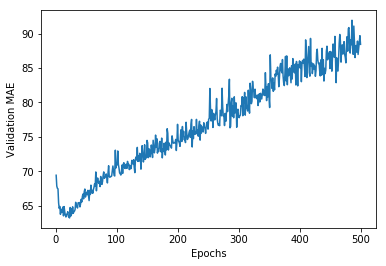

In [153]:
import matplotlib.pyplot as plt

average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

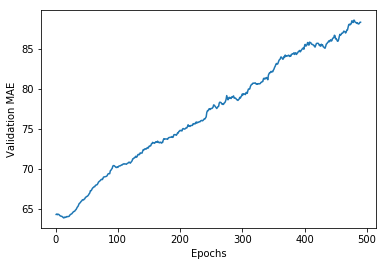

In [154]:
#zoom into the part with the lowest MAE
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [157]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
model.fit(train_data, train_targets,
          epochs=7, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)


100/100 [==============================] - 0s 684us/step


In [158]:
#test score
test_mae_score

72.95929870605468